In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd
from functools import partial
import seaborn as sns
import scipy 
from time import time
import os
from numba import jit, prange, vectorize
np.set_printoptions(suppress=True)

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
tf.enable_eager_execution()

In [4]:
%matplotlib inline

# Model definitions


In [5]:
class ResidualNetwork(tf.keras.Model):
    
    def __init__(self, n_params, logvar=False):
        super(ResidualNetwork, self).__init__()
        
        # Initial simple 1D convolution 
        self.conv_part = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv1D(128, kernel_size=1, strides=1, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ELU(),
        ])
        
        # Sequence of residual blocks
        self.residual_part = tf.keras.Sequential([
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(256),
            ResidualBlock(256)
        ])
        
        # Global average pooling
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        
        # Sequence of FC layers
        self.dense_part = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform')
        ])
        
        # Mean and variance 
        self.mean_part = tf.keras.layers.Dense(n_params, kernel_initializer='glorot_uniform')
        if logvar:
            self.var_part = tf.keras.layers.Dense(n_params, kernel_initializer='glorot_uniform')   
        else:
            self.var_part = tf.keras.layers.Dense(n_params, activation='softplus', kernel_initializer='glorot_uniform') 
        
    def call(self, x, training=True):
        
        x = self.conv_part(x, training=training)
        x = self.residual_part(x, training=training)
        summary = self.avg_pool(x)
        mean = self.mean_part(self.dense_part(summary))
        var = self.var_part(self.dense_part(summary))
        return mean, var
    
    def predict_given_summary(self, summary):
        
        mean = self.mean_part(self.dense_part(summary))
        var = self.var_part(self.dense_part(summary))
        return mean, var    
    
    
class ConvNetwork(tf.keras.Model):
    def __init__(self, n_params):
        super(ConvNetwork, self).__init__()
        
        self.conv_part = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, kernel_size=1, strides=1, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Conv2D(128, kernel_size=2, strides=2, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Conv2D(128, kernel_size=2, strides=2, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Conv2D(256, kernel_size=2, strides=2, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.GlobalAveragePooling2D()
        ])
        
        self.dense_part = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform')
        ])
        
        self.mean_part = tf.keras.layers.Dense(n_params, kernel_initializer='glorot_uniform')
        self.var_part = tf.keras.layers.Dense(n_params, activation='softplus', kernel_initializer='glorot_uniform')
        
    def call(self, x, training=True):
        
        summary = self.conv_part(x, training=training)
        mean = self.mean_part(self.dense_part(summary))
        var = self.var_part(self.dense_part(summary))
        return mean, var

    
class ResidualBlock(tf.keras.Model):
    
    def __init__(self, n_out, kernel_size=2, strides=2):
        super(ResidualBlock, self).__init__()
        
        self.conv_part = tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_out, kernel_size=kernel_size, strides=strides, use_bias=False,
                                   kernel_initializer='glorot_uniform', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ELU(),
            tf.keras.layers.Conv1D(n_out, kernel_size=kernel_size, strides=1, use_bias=False,
                                   kernel_initializer='glorot_uniform', padding='same'),
            tf.keras.layers.BatchNormalization()
        ])
        
        self.downsample = tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_out, kernel_size=1, strides=strides, use_bias=False, 
                                   kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization()
        ])
        
        
    def call(self, x):
        
        identity = x
        out = self.conv_part(x)
        identity = self.downsample(identity)
        out = tf.nn.elu(out + identity)
        return out
    
    
class VAE(tf.keras.Model):
    
    def __init__(self, z_dim, n_params):
        super(VAE, self).__init__()
        self.encoder = ResidualNetwork(z_dim, logvar=True)
        
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(n_params, kernel_initializer='glorot_uniform')
        ])
    
    
    def call(self, x):
        """Encodes, samples and decoded."""
        
        # Encode rt empirical dist
        z_mean, z_logvar = self.encoder(x)
        
        # Sample z
        z_sample = self.reparameterize(z_mean, z_logvar)
    
        # Decode rt and ndt
        decoded = self.decoder(z_sample)
    
        return z_mean, z_logvar, decoded
    
    def reparameterize(self, z_mean, z_logvar):
        """Apply repatrametrization trick."""
        
        eps = tf.random_normal(shape=z_mean.shape)
        return eps * tf.exp(z_logvar * .5) + z_mean

In [6]:
def heteroscedastic_loss(y_true, y_mean, y_var):
    """Computes the heteroscedastic loss as in Radev et al. (2019)."""
    
    logvar = tf.reduce_sum(0.5 * tf.log(y_var), axis=-1)
    squared_error = tf.reduce_sum(0.5 * tf.square(y_true - y_mean) / y_var, axis=-1)
    loss = tf.reduce_mean(squared_error + logvar)
    return loss
      
        
def plot_true_est_scatter(model, y_pred, y_test, params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()
    
    # Initialize figure
    f, axarr = plt.subplots(1, len(params_names), figsize=figsize)

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot true vs estimated
        axarr[j].scatter(y_test[:, j], y_pred[:, j], color='black', alpha=0.4)
        
        # Plot AB line
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmsd = np.sqrt(np.mean( (y_pred[:, j] - y_test[:, j])**2 ))
        nrmsd = rmsd / (y_pred[:, j].max() - y_test[:, j].min())
        axarr[j].text(0.25, 0.9, 'NRMSD={:.3f}'.format(nrmsd),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        # Compute RMSD
        rmsd = np.sqrt(np.mean( (y_pred[:, j] - y_test[:, j])**2 ))
        axarr[j].text(0.25, 0.8, 'RMSD={:.3f}'.format(rmsd),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        # Compute R2
        r2 = r2_score(y_pred[:, j], y_test[:, j])
        axarr[j].text(0.2, 0.7, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('True')
            axarr[j].set_ylabel('Estimated')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_scatter.png".format(filename, Y_test.shape[1]), dpi=600)
      
    
def gaussian_kernel_matrix(x, y, sigmas):
    """
    Computes a Guassian Radial Basis Kernel between the samples of x and y.
    We create a sum of multiple gaussian kernels each having a width sigma_i.
    Args:
    x: a tensor of shape [num_samples, num_features]
    y: a tensor of shape [num_samples, num_features]
    sigmas: a tensor of floats which denote the widths of each of the
      gaussians in the kernel.
    Returns:
    A tensor of shape [num_samples{x}, num_samples{y}] with the RBF kernel.
    """
    
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))
    norm = lambda x: tf.reduce_sum(tf.square(x), 1)
    dist = tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))
    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))
    return tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))


def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix):
    """
    Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.
    Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of
    the distributions of x and y. Here we use the kernel two sample estimate
    using the empirical mean of the two distributions.
    MMD^2(P, Q) = || \E{\phi(x)} - \E{\phi(y)} ||^2
              = \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) },
    where K = <\phi(x), \phi(y)>,
    is the desired kernel function, in this case a radial basis kernel.
    Args:
      x: a tensor of shape [num_samples, num_features]
      y: a tensor of shape [num_samples, num_features]
      kernel: a function which computes the kernel in MMD. Defaults to the
              GaussianKernelMatrix.
    Returns:
      a scalar denoting the squared maximum mean discrepancy loss.
    """

    loss = tf.reduce_mean(kernel(x, x))
    loss += tf.reduce_mean(kernel(y, y))
    loss -= 2 * tf.reduce_mean(kernel(x, y))

    # We do not allow the loss to become negative.
    loss = tf.where(loss > 0, loss, 0)
    return loss


def maximum_mean_discrepancy_loss(source_samples, target_samples, weight=1.):
    """
    This Maximum Mean Discrepancy (MMD) loss is calculated with a number of
    different Gaussian kernels.
    Args:
    source_samples: a tensor of shape [num_samples, num_features].
    target_samples: a tensor of shape [num_samples, num_features].
    weight: the weight of the MMD loss.
    Returns:
    a scalar tensor representing the MMD loss value.
    """
    
    sigmas = [
      1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
      1e3, 1e4, 1e5, 1e6
    ]
    gaussian_kernel = partial(gaussian_kernel_matrix, sigmas=sigmas)
    loss_value = maximum_mean_discrepancy(source_samples, target_samples, kernel=gaussian_kernel)
    loss_value = tf.maximum(1e-4, loss_value) * weight
    return loss_value


def kl_loss(z_mean, z_logvar):
    loss = 1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)
    loss = -0.5 * tf.reduce_sum(loss, axis=-1)
    return tf.reduce_mean(loss)

In [63]:
class RNADataLoader:
    
    def __init__(self, batch_size=32, data_path='.', n_cells=100, n_genes=100, n_sim_chunk=5000):
        
        self.data_path = data_path
        self._batch_size = batch_size
        self._n_cells = n_cells
        self._n_genes = n_genes
        self._n_sim = n_sim_chunk
        self._idx = 0
        self._num_chunks = self._get_num_chunks()
        self._data_files_list = self._get_data_files()
        self._param_files_list = self._get_param_files()
        assert len(self._data_files_list) == len(self._param_files_list), '# Data files in {} must equal # params files'.format(self.path)
    
    def _get_num_chunks(self):
        
        return len(os.listdir(os.path.join(self.data_path, 'data'))) 
    
    def _get_data_files(self):
        
        return [os.path.join(self.data_path, 'data', f) 
                for f in os.listdir(os.path.join(self.data_path, 'data'))]
    
    def _get_param_files(self):
        
        return [os.path.join(self.data_path, 'params', f) 
                for f in os.listdir(os.path.join(self.data_path, 'params'))]
    
    def _get_global_max(self):
        
    
    def load_test(self, n_test, path='.'):
        """Loads a test dataset."""
        
        X = np.load(os.path.join(path, 'rna_data_test.npy')).astype(np.float32)
        y = np.load(os.path.join(path, 'rna_params_test.npy')).astype(np.float32)
        X = X.reshape(self._n_genes, self._n_cells, n_test).T
        X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        return X, y
    
    def _load_next(self):
        """Loads the current data files."""
        
        # Make sure a corresponding pair of data-params is loaded
        data_file = self._data_files_list[self._idx]
        params_file = self._param_files_list[self._idx]
        assert data_file.split('_')[-1] == params_file.split('_')[-1]
        
        # Load as numpy
        X = np.load(data_file).astype(np.float32)
        y = np.load(params_file).astype(np.float32)
        
        # Convert to N_sim x Genes x Cells tensor
        X = X.reshape(self._n_genes, self._n_cells, self._n_sim).T
        
        # Create a tf dataset
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(X.shape[0]).batch(self._batch_size)

        # Increment index and return dataset
        self._idx = self._idx + 1
        return dataset
    
    def __iter__(self): 
        return self
    
    def __next__(self):
        # Increment index and check if we are at the end of the file list 
        if self._idx == self._num_chunks:
            self._idx = 0
            raise StopIteration
            
        return self._load_next()

In [144]:
learning_rate = 0.0001
batch_size = 32
epochs = 30
n_sim = 5000
n_chunks = 25
param_names = ['alpha', 'beta', 'out_loc', 'out_scale', 'lib_loc', 'lib_scale', 'out_prob']
n_params = len(param_names)
#data_loader = RNADataLoader(batch_size)

In [139]:
X_test, y_test = data_loader.load_test(n_test=500)

In [140]:
model = ResidualNetwork(n_params)

In [145]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [142]:
def run_epoch(model, optimizer, data_loader, X_test, y_test, p_bar, global_step=None, clip_value=5.):
    """Runs a single epoch."""
    
    for chunk in data_loader:
        for X_batch, y_batch in chunk:
        
            with tf.GradientTape() as tape:

                # Forward pass
                y_mean, y_var = model(X_batch)

                # Compute total loss
                loss = heteroscedastic_loss(y_batch, y_mean, y_var)
             
            # One step backprop
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # Validations score
            y_mean_val, y_var_val = model(X_test, training=False)
            train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_batch - y_mean), axis=-1), axis=-1))  
            val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_test - y_mean_val), axis=-1), axis=-1))
            val_loss = heteroscedastic_loss(y_test, y_mean_val, y_var_val)
            
            
            if clip_value is not None:
                gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

            # Update p-bar
            p_bar.set_postfix_str("Loss:{0:.3f},Val.Loss:{1:.3f},Rec.:{2:.3f},Val.Rec.:{3:.3f}".format(
            loss.numpy(), val_loss.numpy(), train_rec.numpy() , val_rec.numpy()))
            p_bar.update(1)

In [146]:
for ep in range(1, epochs+1):
    with tqdm(total = (n_sim * n_chunks) // batch_size, desc='Epoch {}'.format(ep)) as p_bar:
        run_epoch(model, optimizer, data_loader, X_test, y_test, p_bar)

KeyboardInterrupt: 

In [85]:
model.save_weights('models/rna')

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


## Evaluate model

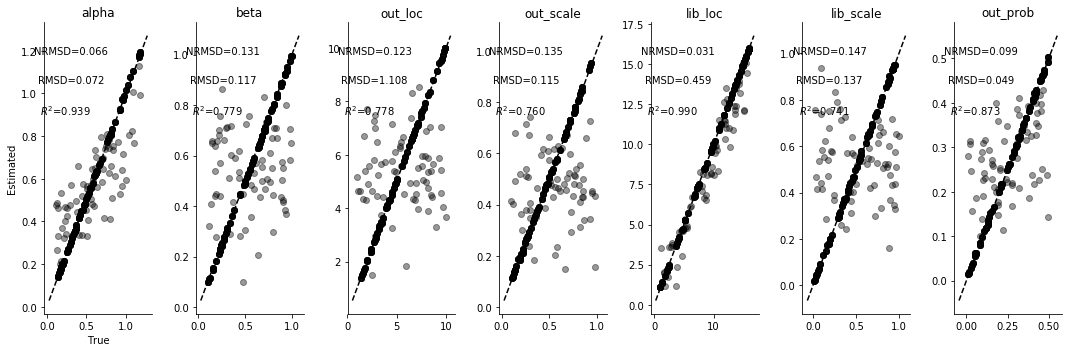

In [148]:
y_pred, y_var = model(X_test, training=True)
plot_true_est_scatter(model, y_pred, y_test, param_names, figsize=(15, 5))

In [149]:
loss = tf.sqrt(tf.reduce_mean((y_pred - y_test) ** 2, axis=1)).numpy()
idx = np.argsort(loss)

In [150]:
idx

array([126, 268, 410, 197, 339, 481, 409, 196, 267, 480, 338, 125, 378,
        94, 236, 165, 307, 449, 495, 211, 424, 282, 353, 140,  98, 311,
       382, 169, 453, 240, 467, 112, 254, 396, 183, 325, 328, 257, 470,
       399, 115, 186,  73, 428, 286, 215, 144, 499, 357, 384, 100, 455,
       171, 242, 313, 296, 154, 438,  83, 225, 367, 388, 175, 317, 104,
       246, 459, 350, 279, 421, 137, 492, 208, 448,  93, 235, 306, 164,
       377, 119, 261, 190, 332, 403, 474, 354, 212, 496, 425,  70, 283,
       141, 250, 321, 179, 392, 108, 463, 221,  79, 150, 363, 292, 434,
       427, 214, 356, 143, 285, 498,  72, 420, 491, 136, 207, 278, 349,
       389, 247, 176, 460, 318, 105, 121, 192, 263, 334, 405, 476, 148,
        77, 290, 361, 219, 432, 161, 232,  90, 374, 445, 303, 482, 340,
       198, 269, 411, 127, 289, 431, 147,  76, 360, 218, 300, 229, 158,
       371,  87, 442, 157,  86, 299, 441, 228, 370, 255, 397, 326, 468,
       184, 113, 308, 166,  95, 379, 450, 237, 473, 118, 189, 33

In [151]:
loss[45]

2.4861953

In [153]:
X_test[45].numpy()

array([[  0.,   1.,   0., ...,   0.,   1.,   1.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [133., 179.,  77., ...,  66.,  57., 129.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  3.,   1.,   7., ...,   1.,   1.,   1.],
       [299., 213., 247., ..., 118., 103., 269.]], dtype=float32)

In [122]:
X_test2[45]

<tf.Tensor: id=30482988, shape=(100, 100), dtype=float32, numpy=
array([[  0.,   1.,   0., ...,   0.,   1.,   1.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [133., 179.,  77., ...,  66.,  57., 129.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  3.,   1.,   7., ...,   1.,   1.,   1.],
       [299., 213., 247., ..., 118., 103., 269.]], dtype=float32)>